In [1]:
import os
import sys
import pickle
import pandas as pd
import geopandas as gpd
import folium
from folium import plugins
import contextily as cx
import matplotlib.pyplot as plt
import warnings
import torch
import numpy as np

In [2]:
def plot_adj_on_map(adj_matrix, map_shp, m):
    for idx, row in enumerate(adj_matrix):
        neighbour_idxs = torch.nonzero(row)
        zone_centroid = [
            map_shp.iloc[idx].geometry.centroid.y,
            map_shp.iloc[idx].geometry.centroid.x,
        ]
        for neighbour_idx in neighbour_idxs:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                neighbour_centroid = [
                    map_shp.iloc[neighbour_idx].geometry.centroid.y,
                    map_shp.iloc[neighbour_idx].geometry.centroid.x,
                ]
                folium.PolyLine([zone_centroid, neighbour_centroid]).add_to(m)
    # add layer controls
    folium.LayerControl().add_to(m)

    return m

def plot_adj_on_map(adj_matrix, map_shp, folium_map):

# Create a geometry list from the GeoDataFrame
    geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in sensor_df.geometry]


    for idx, row in enumerate(adj_matrix):
        neighbour_idxs = torch.nonzero(row)
        zone_centroid = geo_df_list[idx]

        for neighbour_idx in neighbour_idxs:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                neighbour_centroid = geo_df_list[neighbour_idx]
                line = folium.PolyLine([zone_centroid, neighbour_centroid], weight=10).add_to(folium_map)
                plugins.PolyLineTextPath(
                    line,
                    " -> ",
                    repeat=True,
                    center=True,
                    offset=0,
                    attributes={"font-size": "12"},
                ).add_to(folium_map)
    # add layer controls
    folium.LayerControl().add_to(folium_map)

    return folium_map

## Looking at the sensor locations

In [4]:
meta_path = 'dataset_1/jan_17_dataset_metadata.pb'
with open(meta_path, 'rb') as f:
    meta_data = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'dataset_1/jan_17_dataset_metadata.pb'

In [ ]:
flow_cols = meta_data['metadata']['flow_cols']
sensor_df = meta_data['metadata']['sensors_df']
sensor_df = sensor_df.reset_index()
sensor_ordering = sensor_df.ID.unique()
# sensor_ordering

idx_to_id = {k: sensor for k, sensor in enumerate(sensor_ordering)}
id_to_idx = {sensor: k for k, sensor in enumerate(sensor_ordering)}



sensor_df.Dir = sensor_df.Dir.astype('category')

sensor_gdf = gpd.GeoDataFrame(sensor_df,
                              geometry=gpd.points_from_xy(sensor_df.Longitude, 
                                                          sensor_df.Latitude))

sensor_gdf = sensor_gdf.set_crs(epsg=4326)
sensor_gdf = sensor_gdf.to_crs(epsg=3857)

In [ ]:
with open('sensor_idx_to_id.pickle', 'wb') as handle:
    pickle.dump(idx_to_id, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('sensor_idx_to_id.pickle', 'rb') as handle:
    test = pickle.load(handle)

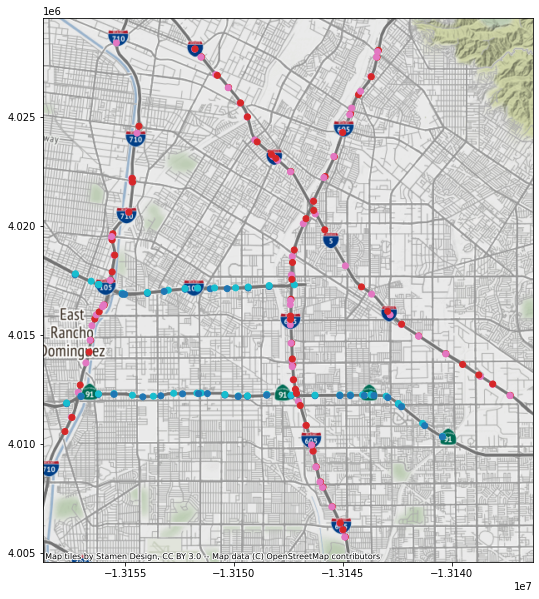

In [ ]:
fig, ax = plt.subplots(1,figsize=(10,10))
sensor_gdf.plot(ax=ax, column=sensor_gdf.Dir)
cx.add_basemap(ax, zoom=12)

In [ ]:
sensor_gdf.Fwy.unique()

array([  5,  91, 105, 605, 710])

In [ ]:
fwy = 5
fwy_mask = sensor_gdf.Fwy == 5
dir_mask = sensor_gdf.Dir == 'N'

In [ ]:
fwy_mask * dir_mask

0      False
1       True
2      False
3      False
4       True
       ...  
210    False
211    False
212    False
213    False
214    False
Length: 215, dtype: bool

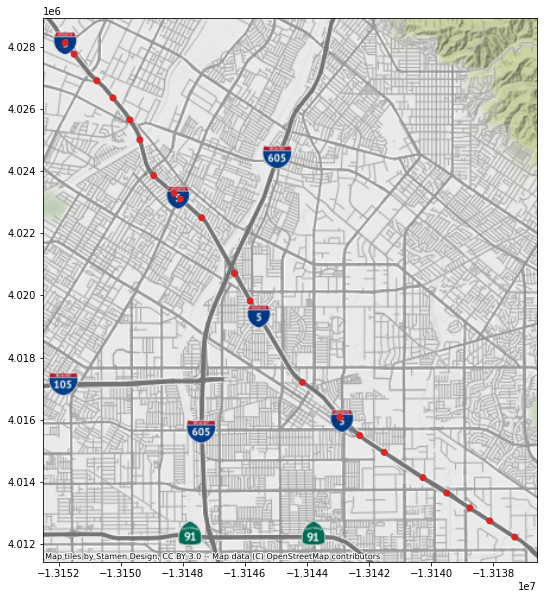

In [ ]:
fig, ax = plt.subplots(1,figsize=(10,10))
sensor_gdf.loc[fwy_mask * dir_mask].plot(ax=ax, column=sensor_gdf.loc[fwy_mask * dir_mask].Dir)
cx.add_basemap(ax, zoom=12)

In [ ]:
sensor_df.Fwy.unique()

array([  5,  91, 105, 605, 710])

In [ ]:
fwy_mask = sensor_df.Fwy == 710
sensor_df[fwy_mask].Dir.unique()

['S', 'N']
Categories (4, object): ['E', 'N', 'S', 'W']

In [ ]:
dir_mask = sensor_df.Dir == 'W'
sub_df = sensor_df[fwy_mask * dir_mask]

## Creating the AD matrix

In [ ]:
adj_test = torch.zeros(215, 215)

# Freeway 5
fwy_mask = sensor_df.Fwy == 5
dir_mask = sensor_df.Dir == 'N'
sub_df = sensor_df[fwy_mask * dir_mask]
sort_df = sub_df.reset_index()
fwy_dir_idxs = [id_to_idx[id] for id in sort_df.sort_values(by=['Latitude']).ID]
for i in range(len(fwy_dir_idxs)-1):
    cur_idx = fwy_dir_idxs[i]
    next_idx = fwy_dir_idxs[i+1]
    adj_test[cur_idx, next_idx] = 1
    
fwy_mask = sensor_df.Fwy == 5
dir_mask = sensor_df.Dir == 'S'
sub_df = sensor_df[fwy_mask * dir_mask]
sort_df = sub_df.reset_index()
sort_df = sort_df.sort_values(by=['Latitude'], ascending=False).ID
fwy_dir_idxs = [id_to_idx[id] for id in sort_df]
for i in range(len(fwy_dir_idxs)-1):
    cur_idx = fwy_dir_idxs[i]
    next_idx = fwy_dir_idxs[i+1]
    adj_test[cur_idx, next_idx] = 1
    
# Freeway 91
fwy_mask = sensor_df.Fwy == 91
dir_mask = sensor_df.Dir == 'E'
sub_df = sensor_df[fwy_mask * dir_mask]
sort_df = sub_df.reset_index()
sort_df = sort_df.sort_values(by=['Longitude']).ID
fwy_dir_idxs = [id_to_idx[id] for id in sort_df]
for i in range(len(fwy_dir_idxs)-1):
    cur_idx = fwy_dir_idxs[i]
    next_idx = fwy_dir_idxs[i+1]
    adj_test[cur_idx, next_idx] = 1

fwy_mask = sensor_df.Fwy == 91
dir_mask = sensor_df.Dir == 'W'
sub_df = sensor_df[fwy_mask * dir_mask]
sort_df = sub_df.reset_index()
sort_df = sort_df.sort_values(by=['Longitude'], ascending=False).ID
fwy_dir_idxs = [id_to_idx[id] for id in sort_df]
for i in range(len(fwy_dir_idxs)-1):
    cur_idx = fwy_dir_idxs[i]
    next_idx = fwy_dir_idxs[i+1]
    adj_test[cur_idx, next_idx] = 1


# Freeway 105
fwy_mask = sensor_df.Fwy == 105
dir_mask = sensor_df.Dir == 'E'
sub_df = sensor_df[fwy_mask * dir_mask]
sort_df = sub_df.reset_index()
sort_df = sort_df.sort_values(by=['Longitude']).ID
fwy_dir_idxs = [id_to_idx[id] for id in sort_df]
for i in range(len(fwy_dir_idxs)-1):
    cur_idx = fwy_dir_idxs[i]
    next_idx = fwy_dir_idxs[i+1]
    adj_test[cur_idx, next_idx] = 1

fwy_mask = sensor_df.Fwy == 105
dir_mask = sensor_df.Dir == 'W'
sub_df = sensor_df[fwy_mask * dir_mask]
sort_df = sub_df.reset_index()
sort_df = sort_df.sort_values(by=['Longitude'], ascending=False).ID
fwy_dir_idxs = [id_to_idx[id] for id in sort_df]
for i in range(len(fwy_dir_idxs)-1):
    cur_idx = fwy_dir_idxs[i]
    next_idx = fwy_dir_idxs[i+1]
    adj_test[cur_idx, next_idx] = 1

    
# Freeway 605
fwy_mask = sensor_df.Fwy == 605
dir_mask = sensor_df.Dir == 'N'
sub_df = sensor_df[fwy_mask * dir_mask]
sort_df = sub_df.reset_index()
fwy_dir_idxs = [id_to_idx[id] for id in sort_df.sort_values(by=['Latitude']).ID]
for i in range(len(fwy_dir_idxs)-1):
    cur_idx = fwy_dir_idxs[i]
    next_idx = fwy_dir_idxs[i+1]
    adj_test[cur_idx, next_idx] = 1
    
fwy_mask = sensor_df.Fwy == 605
dir_mask = sensor_df.Dir == 'S'
sub_df = sensor_df[fwy_mask * dir_mask]
sort_df = sub_df.reset_index()
sort_df = sort_df.sort_values(by=['Latitude'], ascending=False).ID
fwy_dir_idxs = [id_to_idx[id] for id in sort_df]
for i in range(len(fwy_dir_idxs)-1):
    cur_idx = fwy_dir_idxs[i]
    next_idx = fwy_dir_idxs[i+1]
    adj_test[cur_idx, next_idx] = 1
    
# Freeway 710
fwy_mask = sensor_df.Fwy == 710
dir_mask = sensor_df.Dir == 'N'
sub_df = sensor_df[fwy_mask * dir_mask]
sort_df = sub_df.reset_index()
fwy_dir_idxs = [id_to_idx[id] for id in sort_df.sort_values(by=['Latitude']).ID]
for i in range(len(fwy_dir_idxs)-1):
    cur_idx = fwy_dir_idxs[i]
    next_idx = fwy_dir_idxs[i+1]
    adj_test[cur_idx, next_idx] = 1
    
fwy_mask = sensor_df.Fwy == 710
dir_mask = sensor_df.Dir == 'S'
sub_df = sensor_df[fwy_mask * dir_mask]
sort_df = sub_df.reset_index()
sort_df = sort_df.sort_values(by=['Latitude'], ascending=False).ID
fwy_dir_idxs = [id_to_idx[id] for id in sort_df]
for i in range(len(fwy_dir_idxs)-1):
    cur_idx = fwy_dir_idxs[i]
    next_idx = fwy_dir_idxs[i+1]
    adj_test[cur_idx, next_idx] = 1
    
    
## Intersection 1
adj_test[id_to_idx[716449], id_to_idx[717972]] = 1
adj_test[id_to_idx[716449], id_to_idx[768984]] = 1
adj_test[id_to_idx[717770], id_to_idx[716456]] = 1
adj_test[id_to_idx[717770], id_to_idx[716450]] = 1
adj_test[id_to_idx[716457], id_to_idx[717972]] = 1
adj_test[id_to_idx[716457], id_to_idx[768984]] = 1
adj_test[id_to_idx[716857], id_to_idx[760599]] = 1
adj_test[id_to_idx[716857], id_to_idx[716456]] = 1


## Intersection 2
adj_test[id_to_idx[773381], id_to_idx[774372]] = 1
adj_test[id_to_idx[773381], id_to_idx[717968]] = 1
adj_test[id_to_idx[774373], id_to_idx[717396]] = 1
adj_test[id_to_idx[774373], id_to_idx[773382]] = 1
adj_test[id_to_idx[717397], id_to_idx[774372]] = 1
adj_test[id_to_idx[717397], id_to_idx[717968]] = 1
adj_test[id_to_idx[717970], id_to_idx[773382]] = 1
adj_test[id_to_idx[717970], id_to_idx[717396]] = 1

## Intersection 3
adj_test[id_to_idx[716312], id_to_idx[716775]] = 1
adj_test[id_to_idx[716312], id_to_idx[773749]] = 1
adj_test[id_to_idx[717854], id_to_idx[766209]] = 1
adj_test[id_to_idx[717854], id_to_idx[716314]] = 1
adj_test[id_to_idx[717428], id_to_idx[717857]] = 1
adj_test[id_to_idx[717428], id_to_idx[716776]] = 1
adj_test[id_to_idx[716778], id_to_idx[716311]] = 1
adj_test[id_to_idx[716778], id_to_idx[766209]] = 1

# Intersection 4
adj_test[id_to_idx[716470], id_to_idx[718466]] = 1
adj_test[id_to_idx[716470], id_to_idx[717871]] = 1
adj_test[id_to_idx[716784], id_to_idx[716471]] = 1
adj_test[id_to_idx[717872], id_to_idx[716471]] = 1

# Intersection 5
adj_test[id_to_idx[717875], id_to_idx[715920]] = 1
adj_test[id_to_idx[717875], id_to_idx[763985]] = 1
adj_test[id_to_idx[715918], id_to_idx[717879]] = 1
adj_test[id_to_idx[715918], id_to_idx[717877]] = 1
adj_test[id_to_idx[717884], id_to_idx[763985]] = 1
adj_test[id_to_idx[717884], id_to_idx[715920]] = 1
adj_test[id_to_idx[763990], id_to_idx[717877]] = 1
adj_test[id_to_idx[763990], id_to_idx[717879]] = 1

In [ ]:
sensor_df

,index,ID,Fwy,Dir,District,County,City,State_PM,Abs_PM,Latitude,Longitude,Length,Type,Lanes,Name,User_ID_1,User_ID_2,User_ID_3,User_ID_4,geometry
0,0,715898,5,S,7,37,40032.0,.71,117.280,33.880183,-118.021787,0.430,ML,3,PHOEBE,2029,NaN,NaN,NaN,POINT (-118.02179 33.88018)
1,9,715918,5,N,7,37,52526.0,6.2,122.833,33.933110,-118.091005,1.075,ML,3,ORR - DAY,2579,NaN,NaN,NaN,POINT (-118.09100 33.93311)
2,10,715920,5,S,7,37,52526.0,6.64,123.210,33.938544,-118.094941,1.290,ML,4,S OF 605,2296,NaN,NaN,NaN,POINT (-118.09494 33.93854)
3,17,715929,5,S,7,37,19766.0,9.5,126.070,33.971707,-118.123095,0.470,ML,4,GUATEMALA,2023,NaN,NaN,NaN,POINT (-118.12310 33.97171)
4,18,715930,5,N,7,37,19766.0,9.5,126.133,33.971763,-118.122905,0.505,ML,4,GUATEMALA,2023,NaN,NaN,NaN,POINT (-118.12291 33.97176)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,4410,773749,605,N,7,37,12552.0,R5.2,7.252,33.878493,-118.103113,0.165,ML,4,ROUTE 605 / ROUTE 91,2439,NaN,NaN,NaN,POINT (-118.10311 33.87849)
211,4541,774358,710,S,7,37,73080.0,17.7,12.707,33.939200,-118.171985,0.720,ML,4,NORTH OF MILLER WAY,2212,NaN,NaN,NaN,POINT (-118.17199 33.93920)
212,4542,774359,710,N,7,37,73080.0,17.7,12.707,33.939137,-118.171805,0.685,ML,4,NORTH OF MILLER WAY,2212,NaN,NaN,NaN,POINT (-118.17181 33.93914)
213,4543,774372,710,S,7,37,43000.0,12.5,7.540,33.868933,-118.195568,0.610,ML,5,NORTH OF LONG BEACH,2702,NaN,NaN,NaN,POINT (-118.19557 33.86893)


In [ ]:

# Create a geometry list from the GeoDataFrame
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in sensor_df.geometry]

folium_map = folium.Map(location=[33.8, -118.02], tiles="OpenStreetMap", zoom_start=9)

# Iterate through list and add a marker for each volcano, color-coded by its type.
for i, coordinates in enumerate(geo_df_list):
    # assign a color marker for the type of volcano, Strato being the most common
    if sensor_df.Dir.iloc[i] == "N":
        type_color = "green"
    elif sensor_df.Dir.iloc[i] == "S":
        type_color = "blue"
    elif sensor_df.Dir.iloc[i] == "E":
        type_color = "orange"
    elif sensor_df.Dir.iloc[i] == "W":
        type_color = "pink"

    # Place the markers with the popup labels and data
    folium_map.add_child(
        folium.Circle(
            location=coordinates,
            popup=f'{sensor_df.ID.iloc[i]}' , 
            color="%s" % type_color
        )
    )
    
#folium_map = plot_adj_on_map(adj_test, sensor_gdf, folium_map)
folium_map

In [ ]:
plt.imshow(adj_test)

In [ ]:
torch.save(adj_test, 'PEMS_d7_adj.pt')

## Connecting incidents to sensors

In [ ]:
incident_files = os.listdir('dataset_1/incidents')
inci_path = 'dataset_1/incidents'

In [ ]:
inci_arr = []
for incident_file in incident_files:
    path = f'{inci_path}/{incident_file}'
    with open(path, 'rb') as f:
        inci_data = pickle.load(f)
        inci_arr.append(inci_data['acc_info'])
        street, street_dir = inci_data['acc_info'].Street.split('-')[1].split(' ')
        #print(street, street_dir)

In [ ]:
pd.DataFrame(inci_data['flow_before_acc'][715898], columns=flow_cols)[['Timestamp', 'Station', 'Total Flow', 'Avg Occupancy', 'Avg Speed']]

,Timestamp,Station,Total Flow,Avg Occupancy,Avg Speed
0,01/10/2017 19:50:00,715898,303.0,0.0416,68.2
1,01/10/2017 19:55:00,715898,290.0,0.0401,68.3
2,01/10/2017 20:00:00,715898,283.0,0.0389,68.3
3,01/10/2017 20:05:00,715898,279.0,0.0379,68.3
4,01/10/2017 20:10:00,715898,279.0,0.0378,68.8
5,01/10/2017 20:15:00,715898,276.0,0.0378,68.8
6,01/10/2017 20:20:00,715898,271.0,0.037,68.8
7,01/10/2017 20:25:00,715898,267.0,0.0365,68.6
8,01/10/2017 20:30:00,715898,264.0,0.0364,67.4
9,01/10/2017 20:35:00,715898,254.0,0.0356,67.7


In [ ]:
incident_df = pd.DataFrame(inci_arr)

In [ ]:
# Split street name into what have from the meta data
temp_df = incident_df.Street.str.split('-', expand=True)[1].str.split(' ', expand=True)
incident_df['Street_Number'] = temp_df[0]
incident_df['Street_Dir'] = temp_df[1]

incident_df = incident_df.reset_index()


In [ ]:
incident_df

,index,EventId,Type,Severity,TMC,Description,StartTime(UTC),EndTime(UTC),TimeZone,LocationLat,...,AirportCode,Number,Street,Side,City,County,State,ZipCode,Street_Number,Street_Dir
0,296977,T-477973,Accident,3,201,Accident on I-5 Northbound at Exit 124 I-605.,2017-01-22 11:23:55,2017-01-22 11:53:41,US/Pacific,33.944515,...,KCQT,NaN,I-5 N,R,Downey,Los Angeles,CA,90240.0,5,N
1,2181084,T-2768761,Accident,3,201,HOV lane blocked due to accident on I-605 Nort...,2017-01-30 09:31:23,2017-01-30 10:16:00,US/Pacific,33.876656,...,KFUL,NaN,I-605 S,R,Cerritos,Los Angeles,CA,90703.0,605,S
2,271716,T-452712,Accident,2,201,Accident on CA-91 Eastbound at Exits 17 17A 17...,2017-01-11 10:03:19,2017-01-11 10:47:35,US/Pacific,33.876289,...,KFUL,NaN,I-605 S,R,Cerritos,Los Angeles,CA,90703.0,605,S
3,283610,T-464606,Accident,3,201,Accident on I-5 Southbound at Exit 119 Firesto...,2017-01-17 13:18:06,2017-01-17 14:04:00,US/Pacific,33.894295,...,KFUL,NaN,I-5 N,R,Santa Fe Springs,Los Angeles,CA,90670.0,5,N
4,277383,T-458379,Accident,3,201,Accident on I-605 Southbound at Pioneer Blvd.,2017-01-13 18:24:43,2017-01-13 18:54:43,US/Pacific,33.977528,...,KEMT,NaN,I-605 S,R,Whittier,Los Angeles,CA,90606.0,605,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,271752,T-452748,Accident,3,201,Accident on I-105 Eastbound at Exits 13 14 I-710.,2017-01-11 11:56:48,2017-01-11 12:26:26,US/Pacific,33.912704,...,KHHR,NaN,I-105 E,R,Lynwood,Los Angeles,CA,90262.0,105,E
90,299650,T-480646,Accident,3,241,#1 lane blocked due to accident on I-5 Northbo...,2017-01-24 16:07:11,2017-01-24 16:51:54,US/Pacific,33.935226,...,KLGB,NaN,I-5 N,R,Downey,Los Angeles,CA,90241.0,5,N
91,307285,T-488281,Accident,3,201,#1 lane blocked due to accident on I-605 North...,2017-01-27 01:12:26,2017-01-27 01:57:25,US/Pacific,33.876289,...,KFUL,NaN,I-605 S,R,Cerritos,Los Angeles,CA,90703.0,605,S
92,297045,T-478041,Accident,3,201,Accident on I-105 Westbound at Exits 13 14 I-710.,2017-01-22 17:41:10,2017-01-22 18:25:53,US/Pacific,33.912987,...,KLGB,NaN,I-105 W,R,Paramount,Los Angeles,CA,90723.0,105,W


In [ ]:
incident_df.Street.unique() # Where is the 710 and I-5 S, and I-605 N????

array(['I-5 N', 'I-605 S', 'I-105 W', 'I-105 E', 'CA-91 W', 'CA-91 E'],
      dtype=object)

In [ ]:
incident_df.Street_Dir = incident_df.Street_Dir.astype('category')

incident_gdf = gpd.GeoDataFrame(incident_df,
                              geometry=gpd.points_from_xy(incident_df.LocationLng, 
                                                          incident_df.LocationLat))

incident_gdf = incident_gdf.set_crs(epsg=4326)
incident_gdf = incident_gdf.to_crs(epsg=3857)

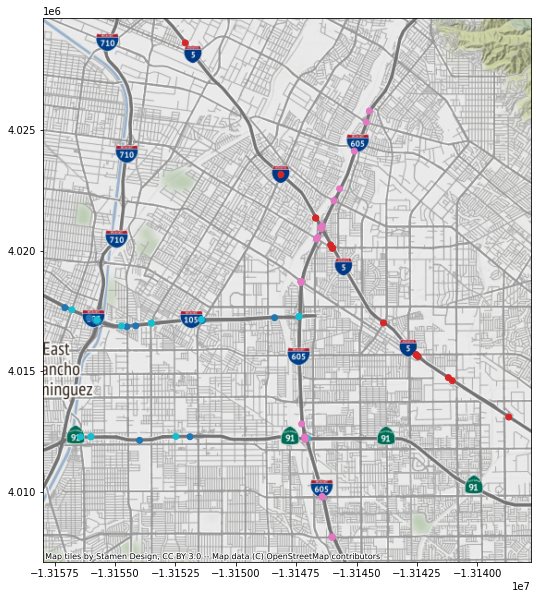

In [ ]:
fig, ax = plt.subplots(1,figsize=(10,10))
incident_gdf.plot(ax=ax, column=incident_gdf.Street_Dir)
cx.add_basemap(ax, zoom=12)

In [ ]:
# Create a geometry list from the GeoDataFrame
geo_df_list_inci = [[point.xy[1][0], point.xy[0][0]] for point in incident_df.geometry]

# Iterate through list and add a marker for each volcano, color-coded by its type.
for i, coordinates in enumerate(geo_df_list_inci):
    # assign a color marker for the type of volcano, Strato being the most common
    if incident_df.Street_Dir.iloc[i] == "N":
        type_color = "darkgreen"
    elif incident_df.Street_Dir.iloc[i] == "S":
        type_color = "darkblue"
    elif incident_df.Street_Dir.iloc[i] == "E":
        type_color = "darkred"
    elif incident_df.Street_Dir.iloc[i] == "W":
        type_color = "lightred"
    
        # Place the markers with the popup labels and data
    folium_map.add_child(
        folium.Marker(
            location=coordinates,
            popup=f'{incident_df.iloc[i]}' , 
            icon=folium.Icon(color="%s" % type_color, icon='glyphicon glyphicon-warning-sign'),
        )
    )
    
#folium_map

In [ ]:
closest_sensor_arr = []

for i, incident_row in incident_df.iterrows():
    street_mask = sensor_df.Fwy == int(incident_row.Street_Number)
    dir_mask = sensor_df.Dir == incident_row.Street_Dir
    sub_df = sensor_df[street_mask * dir_mask]
    sort_df = sub_df.reset_index()
    
    if incident_row.Street_Dir == 'N':
        sort_df = sort_df.sort_values(by=['Latitude'])
        sort_idx = sort_df.Latitude.searchsorted(incident_row.LocationLat) - 1
        closest_sensor_id = sort_df.iloc[sort_idx].ID
        closest_sensor_idx = id_to_idx[closest_sensor_id]
        closest_sensor_arr.append(closest_sensor_idx)
        
    elif incident_row.Street_Dir == 'S':
        sort_df = sort_df.sort_values(by=['Latitude'])
        sort_idx = sort_df.Latitude.searchsorted(incident_row.LocationLat)
        closest_sensor_id = sort_df.iloc[sort_idx].ID
        closest_sensor_idx = id_to_idx[closest_sensor_id]
        closest_sensor_arr.append(closest_sensor_idx)
        
    elif incident_row.Street_Dir == 'E':
        sort_df = sort_df.sort_values(by=['Longitude'])
        sort_idx = sort_df.Longitude.searchsorted(incident_row.LocationLng) - 1
        closest_sensor_id = sort_df.iloc[sort_idx].ID
        closest_sensor_idx = id_to_idx[closest_sensor_id]
        closest_sensor_arr.append(closest_sensor_idx)

    elif incident_row.Street_Dir == 'W':
        sort_df = sort_df.sort_values(by=['Longitude'])
        sort_idx = sort_df.Longitude.searchsorted(incident_row.LocationLng)
        closest_sensor_id = sort_df.iloc[sort_idx].ID
        closest_sensor_idx = id_to_idx[closest_sensor_id]
        closest_sensor_arr.append(closest_sensor_idx)
    else:
        print(incident_row.Street_Dir)

In [ ]:
incident_df['closest_sensor_idx'] = closest_sensor_arr
incident_df['closest_sensor_id'] = incident_df['closest_sensor_idx'].map(idx_to_id)

incident_df['StartTime(UTC)'] = pd.to_datetime(incident_df['StartTime(UTC)'], format='%Y-%m-%d %H:%M:%S')
incident_df['EndTime(UTC)'] = pd.to_datetime(incident_df['EndTime(UTC)'], format='%Y-%m-%d %H:%M:%S')

incident_df['Duration'] = (incident_df['EndTime(UTC)'] - incident_df['StartTime(UTC)']) / np.timedelta64(1, 's')

In [ ]:
# Create a geometry list from the GeoDataFrame
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in sensor_df.geometry]
geo_df_list_inci = [[point.xy[1][0], point.xy[0][0]] for point in incident_df.geometry]


for idx, row in incident_df.iterrows():
    sensor_idx = row.closest_sensor_idx
    incident_centroid = geo_df_list_inci[idx]
    sensor_centroid = geo_df_list[sensor_idx]
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        line = folium.PolyLine([incident_centroid, sensor_centroid], weight=10).add_to(folium_map)
        plugins.PolyLineTextPath(
            line,
            " -> ",
            repeat=True,
            center=True,
            offset=0,
            attributes={"font-size": "12"},
        ).add_to(folium_map)
# add layer controls
folium.LayerControl().add_to(folium_map)

In [ ]:
incident_df[['closest_sensor_idx', 'Severity', 'TMC', 'Duration']]

,closest_sensor_idx,Severity,TMC,Duration
0,184,3,201,1786.0
1,26,3,201,2677.0
2,26,2,201,2656.0
3,174,3,201,2754.0
4,118,3,201,1800.0
...,...,...,...,...
89,143,3,201,1778.0
90,1,3,241,2683.0
91,26,3,201,2699.0
92,167,3,201,2683.0


<AxesSubplot:>

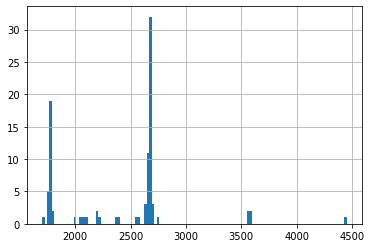

In [ ]:
incident_df.Duration.hist(bins=125)

### Load HA model

## Potential problem with multiple names for same road

In [ ]:
lstw = pd.read_csv('TrafficEvents_Aug16_Dec20_Publish.csv', usecols = ['EventId', 'City', 'County', 'Street', 'LocationLat', 'LocationLng'])
lstw = lstw[lstw.County == 'Los Angeles']
lat_mask = lstw.LocationLat.between(sensor_df.Latitude.min(), sensor_df.Latitude.max())
lng_mask = lstw.LocationLng.between(sensor_df.Longitude.min(), sensor_df.Longitude.max())
test1_df = lstw[lstw.Street.isin(['Long Beach Fwy N','Long Beach Fwy S'])]
test2_df = lstw[lstw.Street.isin(['I-710 S', 'I-710 N'])]

test1_gdf = gpd.GeoDataFrame(test1_df,
                              geometry=gpd.points_from_xy(test1_df.LocationLng, 
                                                          test1_df.LocationLat))

test1_gdf = test1_gdf.set_crs(epsg=4326)
test1_gdf = test1_gdf.to_crs(epsg=3857)

test2_gdf = gpd.GeoDataFrame(test2_df,
                              geometry=gpd.points_from_xy(test2_df.LocationLng, 
                                                          test2_df.LocationLat))


test2_gdf = test2_gdf.set_crs(epsg=4326)
test2_gdf = test2_gdf.to_crs(epsg=3857)


geo_df_test1 = [[point.xy[1][0], point.xy[0][0]] for point in test1_df.geometry][:40]
geo_df_test2= [[point.xy[1][0], point.xy[0][0]] for point in test2_df.geometry][:40]
len(geo_df_test1)

folium_map = folium.Map(location=[33.8, -118.02], tiles="OpenStreetMap", zoom_start=9)
# Iterate through list and add a marker for each volcano, color-coded by its type.
for i, coordinates in enumerate(geo_df_test1):
        # Place the markers with the popup labels and data
    folium_map.add_child(
        folium.Marker(
            location=coordinates,
            popup=f'{test1_df.iloc[i]}' , 
            icon=folium.Icon(color="red", icon='glyphicon glyphicon-warning-sign'),
        )
    )


for i, coordinates in enumerate(geo_df_test2):
        # Place the markers with the popup labels and data
    folium_map.add_child(
        folium.Marker(
            location=coordinates,
            popup=f'{test2_df.iloc[i]}' , 
            icon=folium.Icon(color="blue", icon='glyphicon glyphicon-warning-sign'),
        )
    )

folium_map